First part on accuracy.

Metrics such as:
- peptide recall/accuracy
- amino acid recall/accuracy

In [1]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

2025-01-18 16:42:14.254892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 16:42:14.279228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 16:42:14.285986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


Due to memory constraints, the notebook is run 3 times with different datasets seperately.

1. For clean samples: PXD028735

Selected runs:
[
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

A single PR curve is made for the results combined, 1 with peptide accuracy, the other with amino acid accuracy

Below, a barplot is created showing the total peptide accuracy (upper) and peptide recall (lower) for the datasets seperately.

2. For timsTOF or TTOF6600 data on clean samples: PXD028735 (Data not yet acquired)

Selected runs: Same set as in (1)

For now, results from metaproteomics can be shown acquired on a bruker instrument (TOF)

3. Metaproteomics sample (some S and F files)

A single PR curve for both S and F files combined, with 1 peptide accuracy and the other amino acid accuracy

Below, a barplot showing total peptide accuracy and recall for S and F samples seperately.

S samples are SIHUMIX and is a mock community. F samples an even more complex fecal sample.

In [319]:
from denovo_utils.io.read import load_psmlist

load_psmlist('/public/compomics3/Sam/PXD028735/QExactive/rescoring/LFQ_Orbitrap_DDA_Ecoli_01/psmlist/casanovo.instanovoplus.parquet')[0]['provenance_data']

100%|██████████| 61866/61866 [00:04<00:00, 12977.66it/s]


{'before_rescoring_score': -0.5462782979011536,
 'score_ms2rescore': -112.77850514293736}

In [323]:
load_psmlist('/public/compomics3/Sam/PXD028735/QExactive/rescoring/LFQ_Orbitrap_DDA_Ecoli_01/psmlist/casanovo.parquet')[0]['provenance_data']

100%|██████████| 61876/61876 [00:06<00:00, 9445.63it/s] 


{'before_rescoring_score': -0.5985946261457035,
 'score_ms2rescore': -6.81034736462222}

# 1. Read in the data

In [3]:
root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/denovo_output'
root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'
run_names = [
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

engine_names = [
    'adanovo',
    'pihelixnovo',
    'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

runs = {}
for run_name in run_names:
    print(f"Run: {run_name}")
    run = Run(run_name)

    mgf_path = os.path.join(root_mgf, run_name + '.mgf')

    parser = DenovoEngineConverter.select('sage')
    psmlist_gt = parser.parse(
        result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
        mgf_path=mgf_path
    )
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=[],
        is_ground_truth=True
    )

    for engine_name in engine_names:
        print(f'loading {engine_name}')
        parser = DenovoEngineConverter.select(engine_name)
        psmlist_denovo = parser.parse(
            result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
            mgf_path=mgf_path
        )
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=[],
            is_ground_truth=False
        )
    
    runs[run_name] = run

Run: LFQ_Orbitrap_DDA_Ecoli_01


100%|██████████| 24285/24285 [00:00<00:00, 39960.42it/s]


loading adanovo


100%|██████████| 61843/61843 [00:01<00:00, 52573.45it/s]


loading pihelixnovo


100%|██████████| 61955/61955 [00:00<00:00, 80495.59it/s]


loading piprimenovo


100%|██████████| 58682/58682 [00:00<00:00, 88512.62it/s] 


loading casanovo


100%|██████████| 61876/61876 [00:01<00:00, 47691.93it/s]


loading instanovo


100%|██████████| 61562/61562 [00:00<00:00, 86280.29it/s] 


loading contranovo


100%|██████████| 30999/30999 [00:00<00:00, 45447.68it/s]


loading novob


100%|██████████| 61479/61479 [00:02<00:00, 21177.84it/s]


loading pepnet


100%|██████████| 62560/62560 [00:01<00:00, 47200.00it/s]


Run: LFQ_Orbitrap_DDA_Human_01


100%|██████████| 90817/90817 [00:05<00:00, 16878.63it/s]


loading adanovo


100%|██████████| 115178/115178 [00:07<00:00, 16199.33it/s]


loading pihelixnovo


100%|██████████| 115417/115417 [00:01<00:00, 68974.81it/s]


loading piprimenovo


100%|██████████| 111287/111287 [00:01<00:00, 73055.28it/s]


loading casanovo


100%|██████████| 115362/115362 [00:07<00:00, 14543.12it/s]


loading instanovo


100%|██████████| 114725/114725 [00:01<00:00, 73767.83it/s]


loading contranovo


100%|██████████| 57640/57640 [00:01<00:00, 36827.23it/s]


loading novob


100%|██████████| 114067/114067 [00:07<00:00, 16057.69it/s]


loading pepnet


100%|██████████| 118245/118245 [00:03<00:00, 38897.63it/s]


Run: LFQ_Orbitrap_DDA_QC_01


100%|██████████| 83941/83941 [00:01<00:00, 63784.96it/s]


loading adanovo


100%|██████████| 107088/107088 [00:09<00:00, 11318.87it/s]


loading pihelixnovo


100%|██████████| 107182/107182 [00:01<00:00, 68950.33it/s]


loading piprimenovo


100%|██████████| 103511/103511 [00:01<00:00, 73829.14it/s]


loading casanovo


100%|██████████| 107203/107203 [00:02<00:00, 39012.00it/s]


loading instanovo


100%|██████████| 106604/106604 [00:01<00:00, 75003.49it/s]


loading contranovo


100%|██████████| 53533/53533 [00:01<00:00, 37210.00it/s]


loading novob


100%|██████████| 106078/106078 [00:01<00:00, 75094.13it/s]


loading pepnet


100%|██████████| 109340/109340 [00:02<00:00, 39317.58it/s]


Run: LFQ_Orbitrap_DDA_Yeast_01


100%|██████████| 67111/67111 [00:01<00:00, 43265.54it/s]


loading adanovo


100%|██████████| 102427/102427 [00:03<00:00, 32375.89it/s]


loading pihelixnovo


100%|██████████| 102483/102483 [00:01<00:00, 62294.03it/s]


loading piprimenovo


100%|██████████| 96975/96975 [00:01<00:00, 59940.93it/s]


loading casanovo


100%|██████████| 102518/102518 [00:17<00:00, 5768.31it/s] 


loading instanovo


100%|██████████| 101883/101883 [00:01<00:00, 61891.55it/s]


loading contranovo


100%|██████████| 51215/51215 [00:01<00:00, 30843.56it/s]


loading novob


100%|██████████| 101183/101183 [00:01<00:00, 63432.67it/s]


loading pepnet


100%|██████████| 103785/103785 [00:03<00:00, 32457.89it/s]


Redo but for all 4 runs together

In [61]:
def get_ppms(spectrum):
    ppms = {}
    
    gt = spectrum.psm_gt
    for psm_candidate in spectrum.psm_candidates:
        ppms[psm_candidate.engine_name] = calculate_ppm(
            m1=psm_candidate.peptidoform.theoretical_mz,
            m2=gt.peptidoform.theoretical_mz,
            isotopes=[-1,0,1,2],
            charge=gt.peptidoform.precursor_charge
        )
    return ppms

In [63]:
ppms = []
for spectrum in tqdm(run.spectra.values()):
    ppms.append(get_ppms(spectrum))

100%|██████████| 41787/41787 [00:09<00:00, 4630.67it/s]


In [64]:
import pandas as pd
(pd.DataFrame(ppms)==50).melt().value_counts()

variable      value
instanovo     False    41289
contranovo    False    41214
novob         False    40770
pi-PrimeNovo  False    40487
casanovo      False    34588
AdaNovo       False    32320
pi-HelixNovo  False    31675
pepnet        False    23534
              True     18253
pi-HelixNovo  True     10112
AdaNovo       True      9467
casanovo      True      7199
pi-PrimeNovo  True      1300
novob         True      1017
contranovo    True       573
instanovo     True       498
dtype: int64

In [4]:
runs

{'LFQ_Orbitrap_DDA_Ecoli_01': 15775 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).,
 'LFQ_Orbitrap_DDA_Human_01': 63815 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).,
 'LFQ_Orbitrap_DDA_QC_01': 58559 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).,
 'LFQ_Orbitrap_DDA_Yeast_01': 41787 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).}

# 2. Peptide recall for common spectra, or based on db coverage

In [5]:
for run in runs.values():
    for spectrum in run.spectra.values():
        spectrum.compare_gt(
            'sage',
            ignore_score=True
        )

In [6]:
denovo_engines = ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo', 'pi-PrimeNovo', 'AdaNovo', 'pi-HelixNovo']

In [99]:
def get_match_score_tables(runs, common_spectra=True):

    tables_by_run = {}
    for filename, run in runs.items():
        if common_spectra:
            run_engine = run.get_common_spectra(engines=denovo_engines)

        tables = {}
        for engine in denovo_engines:
            if not common_spectra:
                run_engine = run.get_common_spectra([engine])
            t = get_match_score_table(
                run_engine,
                engine=engine,
                score_metadata=engine,
                eval_score_metadata='sage',
                refiner=None,
                return_table=True
            )
            tables[engine] = t

        tables_by_run[filename] = tables
    
    pr_tables = {engine: [] for engine in denovo_engines}
    for filename, tables in tables_by_run.items():
        for engine, table in tables.items():
            pr_tables[engine].append(table)
    
    pr_tables = {engine: pd.concat(tables, ignore_index=True) for engine, tables in pr_tables.items()}
    return pr_tables

In [127]:
pr_tables_common_spectra = get_match_score_tables(runs=runs, common_spectra=True)
pr_tables_all_spectra = get_match_score_tables(runs=runs, common_spectra=False)

In [ ]:
# Calculate precision recall coverage when defined on common spectra
pr_rec_cov_dict = {}
for engine, tables in pr_tables_common_spectra.items():
    
    # total predicted here means all common spectra (shape of very df here)
    prc = get_prc_curve(tables, len(tables))
    pr_rec_cov_dict[engine] = {
        'precision': prc.precision.to_numpy(),
        'recall': prc.recall.to_numpy(),
        'coverage': prc.coverage.to_numpy()
    }

# Calculate precision recall coverage on complete set of database results
# total predicted here means all db results
all_db_peptides = sum([len(run.spectra.keys()) for run in runs.values()])
pr_rec_cov_dict_all = {}
for engine, tables in pr_tables_all_spectra.items():
    prc = get_prc_curve(tables, all_db_peptides)
    pr_rec_cov_dict_all[engine] = {
        'precision': prc.precision.to_numpy(),
        'recall': prc.recall.to_numpy(),
        'coverage': prc.coverage.to_numpy()
    }

Create the first PC plot on common spectra only to check performance on a common set irrespective whether some tool happens to not give a prediction to something

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


Text(0, 0.5, 'Peptide Precision')

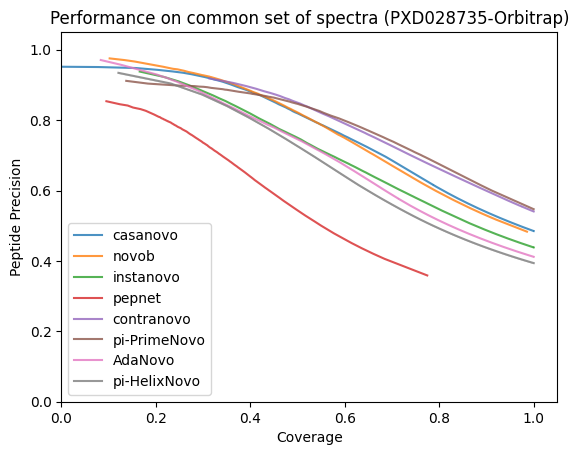

In [129]:
# plotting a precision coverage curve
for engine, pr_dict in pr_rec_cov_dict.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["coverage"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("Performance on common set of spectra (PXD028735-Orbitrap)")
plt.xlabel('Coverage')
plt.ylabel('Peptide Precision')

plotting casanovo
plotting novob
plotting instanovo
plotting pepnet
plotting contranovo
plotting pi-PrimeNovo
plotting AdaNovo
plotting pi-HelixNovo


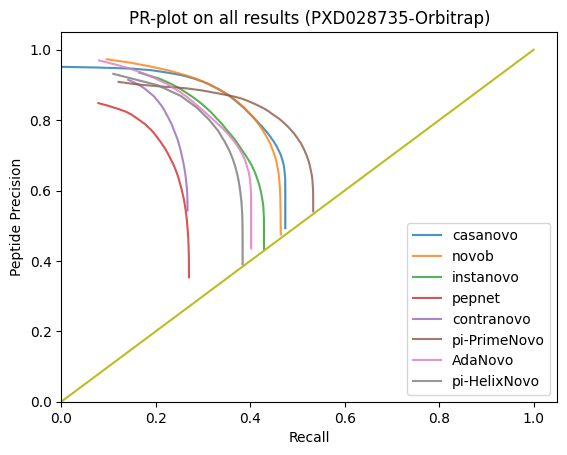

In [137]:
# Create the precision recall curve where recall means correct/n_database_results, which equals precision when all predictions are considered
for engine, pr_dict in pr_rec_cov_dict_all.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["recall"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.title("PR-plot on all results (PXD028735-Orbitrap)")
plt.xlabel('Recall')
plt.ylabel('Peptide Precision')
plt.plot((0,1), (0,1))

# 3. Barplots showing Precision and Coverage by sample type

In [213]:
barplot_data = {
    'engine': [],
    'run': [],
    'precision': [],
    'coverage': []
}

for engine in denovo_engines:
    engine_performance = {}

    for run_name, run in runs.items():

        n_all = len(run.spectra)
        run_engine = run.get_common_spectra(engines=[engine])
        n_predicted = len(run_engine.spectra)
        n_correct = 0
        for spectrum in run_engine.spectra.values():
            psm = spectrum.get_psms_by_engine(engine)[0]
            if psm.evaluation['sage'].error_type=="match":
                n_correct += 1

        coverage = n_predicted/n_all
        precision = n_correct/n_predicted
        
        barplot_data['coverage'].append(coverage)
        barplot_data['precision'].append(precision)
        barplot_data['engine'].append(engine)
        barplot_data['run'].append(run_name)

In [233]:
barplot_data = pd.DataFrame(barplot_data).sort_values(by='precision')

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_precision_coverage_barplot(barplot_data):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the first barchart (pointing to the right)
    bar1 = sns.barplot(data=barplot_data, y='run', x='precision', hue='engine', ax=ax)

    # Plot the second barchart (pointing to the left)
    bar2 = sns.barplot(data=barplot_data, y='run', x=[-v for v in barplot_data['coverage']], hue='engine', ax=ax)

    # Add the vertical line at x=0
    ax.axvline(0, color='black', linewidth=1)

    # Customize the plot
    ax.set_ylabel('Sample type')

    # Set x-axis limits to ensure symmetry
    max_val = max(max(barplot_data['precision']), max(barplot_data['coverage']))
    ax.set_xlim(-int(max_val), int(max_val))
    ax.set_xticks(range(-int(max_val), int(max_val) + 1, 5))

    # Remove default x-axis label
    ax.set_xlabel('')

    # Add custom x-axis labels for Precision and Coverage
    ax.text(max_val / 2, -0.7, 'Precision', va='center', ha='center', fontsize=12)
    ax.text(-max_val / 2, -0.7, 'Coverage', va='center', ha='center', fontsize=12)

    # Adjust the legend to appear outside the plot
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict(zip(labels, handles)).items())
    ax.legend(
        [handle for _, handle in unique_labels],
        [label for label, _ in unique_labels],
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        title="De novo tool"
    )

    for p in bar1.patches:
        width = p.get_width()  # Get the width of the bar
        percentage = (width / max_val) * 100  # Calculate the percentage of max width
        ax.annotate(f'{abs(percentage):.2f}%', (p.get_width(), p.get_y() + p.get_height() / 2),
                    va='center', ha='left', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()


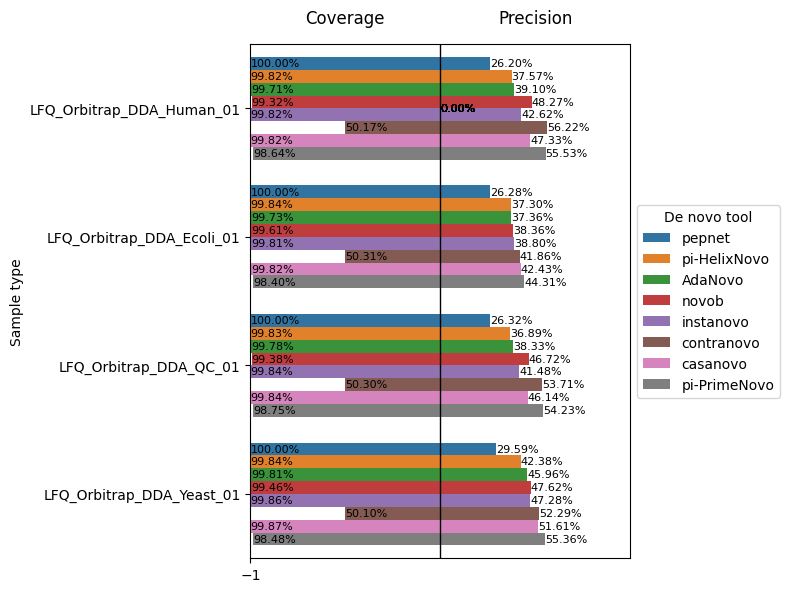

In [237]:
plot_precision_coverage_barplot(barplot_data)

## 3. Amino acid recall/coverage

Accuracy = correct / predictions above threshold
Recall = correct / n_amino_acids in ground truth

In [313]:
from denovo_utils.analysis.metrics import aa_match, convert_peptidoform
import numpy as np

aa_engines = ['contranovo', 'AdaNovo', 'casanovo', 'pepnet']

aa_pr_engine = {}

total_aa_gt_counted = False
total_aa_gt = 0

for run in runs.values():
    for spectrum in run.spectra.values():
        total_aa_gt += len(spectrum.psm_gt.peptidoform)
        if spectrum.psm_gt.peptidoform.properties['n_term'] is not None:
            total_aa_gt += 1


for engine in aa_engines:
    print(engine)
    run_engine = run.get_common_spectra([engine])

    scores_aa = []
    match_aa = []
    for run in runs.values():
        for spectrum in tqdm(run_engine.spectra.values()):
            psm_gt = spectrum.psm_gt
            psm_dn = spectrum.get_psms_by_engine(engine)[0]
            scores = list(psm_dn.scores.get_score(metadata=engine, score_type='aa'))

            _, pep_match, (match_1, match_2), iso_errs, tols = aa_match(
                convert_peptidoform(psm_dn.peptidoform),
                convert_peptidoform(psm_gt.peptidoform),
                aa_dict={}
            )


            if engine == 'contranovo':
                while len(scores) != len(match_1):
                    n_term_score = np.mean(scores[:2])
                    scores = scores[1::]
                    scores[0] = n_term_score
            
            assert len(match_1) == len(scores)
            scores_aa += scores
            match_aa += match_1.tolist()
           
    tables_df = pd.DataFrame(
        {'score': scores_aa, 'match': match_aa}
    )
    aa_pr_engine[engine] = get_prc_curve(
        tables_df,
        total_predicted=total_aa_gt
    )

contranovo


100%|██████████| 20936/20936 [00:01<00:00, 14509.79it/s]
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


AdaNovo


100%|██████████| 41709/41709 [00:03<00:00, 13326.83it/s]
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


casanovo


100%|██████████| 41734/41734 [00:02<00:00, 14461.07it/s]
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


pepnet


100%|██████████| 41787/41787 [00:03<00:00, 12335.44it/s]
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci


plotting contranovo
plotting AdaNovo
plotting casanovo
plotting pepnet


Text(0, 0.5, 'Amino Acid Precision')

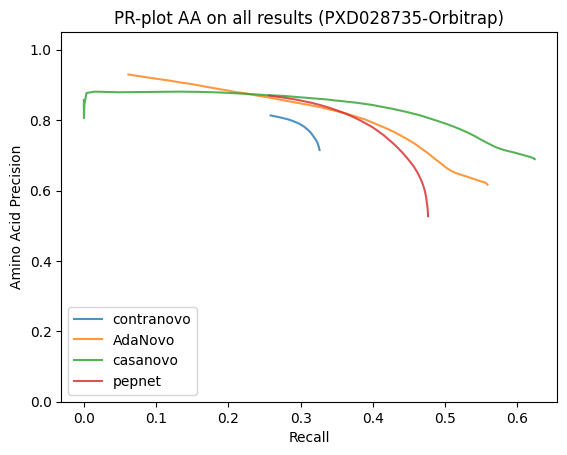

In [314]:
# Create the precision recall curve where recall means correct/n_database_results, which equals precision when all predictions are considered
for engine, pr_dict in aa_pr_engine.items():
    print("plotting", engine)
    sns.lineplot(
        x=pr_dict["recall"],
        y=pr_dict["precision"],
        label=engine,   # Label for style legend
        alpha=.8,
    )

plt.ylim((0,1.05))
plt.title("PR-plot AA on all results (PXD028735-Orbitrap)")
plt.xlabel('Recall')
plt.ylabel('Amino Acid Precision')